# Credit Card Fraud Detection with SMOTE and Tree-Based Classifiers

This notebook implements a comprehensive fraud detection pipeline using tree-based models, SMOTE for class balancing, and robust evaluation practices.

It draws inspiration from the principles outlined in the [Fraud Detection Handbook](https://fraud-detection-handbook.github.io/fraud-detection-handbook/Foreword.html), which emphasizes the importance of proper validation, class imbalance handling, and meaningful metrics like AUPRC in high-skew settings like fraud detection.


## Data Preprocessing

Credit card fraud detection requires careful preprocessing due to the highly skewed nature of the data and the presence of anonymized features.

We standardize the `Amount` feature using `StandardScaler` to ensure fair weight distribution across models and drop the `Time` column which does not contribute predictive power in this context.

This prepares our features for both gradient-boosting models and interpretable models like Logistic Regression.


## Handling Class Imbalance with SMOTE

In highly imbalanced settings (fraud rate < 0.2%), models trained on raw data will often predict only the majority class. To address this:

- We use **SMOTE (Synthetic Minority Oversampling Technique)** which creates new synthetic minority examples based on feature space similarity.
- This allows models to generalize better without overfitting.
- Unlike random oversampling, SMOTE preserves diversity in minority examples.

The Fraud Detection Handbook emphasizes SMOTE as a critical technique in offline evaluation, before temporal or live validation is considered.


## Model Training

We train a series of classifiers on the balanced dataset to compare their performance in a reproducible way.

Key models explored:
- **XGBoost**: Handles tabular, non-linear patterns efficiently.
- **Logistic Regression**: A robust and interpretable baseline.
- **LightGBM & CatBoost**: Fast gradient boosting models optimized for large datasets with categorical features.

Each model is trained and evaluated using a consistent pipeline for fairness.


## Model Evaluation

Because accuracy is misleading in imbalanced datasets, we use the following metrics:

- **Precision**: Accuracy of positive (fraud) predictions.
- **Recall**: Coverage of actual fraud cases.
- **F1 Score**: Balance between precision and recall.
- **ROC-AUC**: General discrimination ability of the model.
- **AUPRC (planned)**: More informative for rare event detection.

This is consistent with the Fraud Detection Handbook's emphasis on cost-sensitive metrics.


## Visualizations

Visual diagnostics help us understand model performance:

- **Confusion Matrix**: Visualizes false positives and false negatives.
- **ROC Curve**: Shows tradeoff between sensitivity and specificity.
- **(Planned)**: AUPRC and threshold-based precision-recall tradeoffs for deeper insight into model confidence.


## Export Results

All key outputs are stored to CSVs in `Data/output/` to support:

- Auditable results tracking
- Integration with dashboards (e.g. Power BI, Streamlit)
- Model comparison reports
- Reproducibility for experiment logging

The structure supports iterative ML development as recommended in operational fraud detection systems.


## 1. Load Input Data
This step reads input data required for training or evaluation from the specified CSV files.

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    confusion_matrix, accuracy_score, f1_score,
    precision_score, recall_score, roc_curve,
    auc, roc_auc_score, ConfusionMatrixDisplay, RocCurveDisplay
)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from imblearn.over_sampling import SMOTE

# Load dataset
DATA_PATH = Path("Data") / "creditcard.csv"
assert DATA_PATH.exists(), f"Dataset not found at {DATA_PATH}"
dataset = pd.read_csv(DATA_PATH)

# Preprocess
scaler = StandardScaler()
card2 = dataset.copy()
card2['Scaled_Amount'] = scaler.fit_transform(card2['Amount'].values.reshape(-1, 1))
card2 = card2.drop(['Amount', 'Time'], axis=1)

# Transform full dataset for prediction
card4 = dataset.copy()
card4['Scaled_Amount'] = scaler.transform(card4['Amount'].values.reshape(-1, 1))
card4 = card4.drop(['Amount', 'Time'], axis=1)

# Features and target
X = card2.drop('Class', axis=1)
y = card2['Class']
X_full = card4.drop('Class', axis=1)
assert list(X.columns) == list(X_full.columns), "Feature mismatch"

# SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=0)

## 2. Train XGBoost Model
We initialize and train an XGBoost classifier using the balanced dataset.

Training Score: 0.99997
Test Score: 0.99967


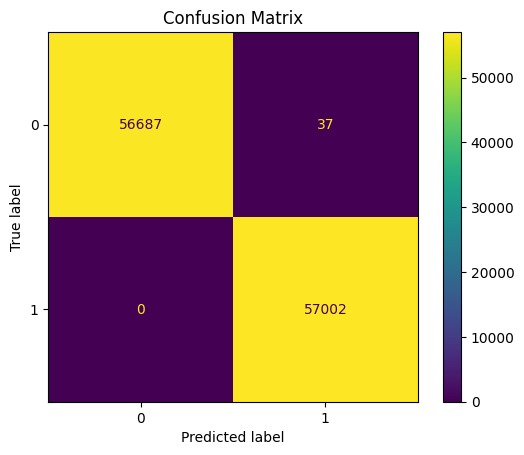

   Accuracy  Recall  Precision  F1 Score
0    0.9997     1.0     0.9994    0.9997


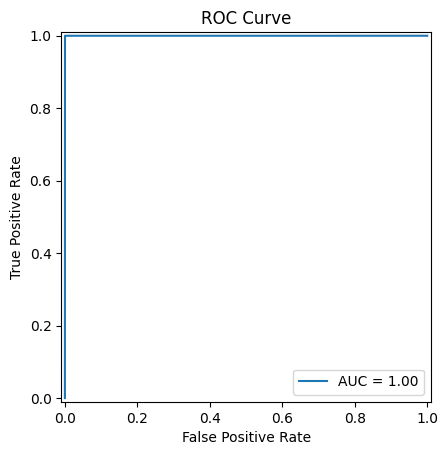

In [2]:
# Train XGBoost
xgb = XGBClassifier(eval_metric='logloss', random_state=42, enable_categorical=False)
xgb.fit(X_train, y_train)

# Evaluation
train_score = xgb.score(X_train, y_train)
test_score = xgb.score(X_test, y_test)
print(f"Training Score: {train_score:.5f}")
print(f"Test Score: {test_score:.5f}")

# Predictions
xgb_preds = xgb.predict(X_test)
xgb_preds_prob = xgb.predict_proba(X_test)[:, 1]
xgb_preds_full = xgb.predict(X_full)
xgb_preds_full_prob = xgb.predict_proba(X_full)[:, 1]

# Add predictions to original dataset
dataset3 = dataset.copy()
dataset3['predictions'] = xgb_preds_full
dataset3['predictions_prob'] = xgb_preds_full_prob

# Confusion Matrix and Metrics
cm = confusion_matrix(y_test, xgb_preds)
ConfusionMatrixDisplay(cm).plot()
plt.title('Confusion Matrix')
plt.show()

metrics = pd.DataFrame({
    'Accuracy': [round(accuracy_score(y_test, xgb_preds), 4)],
    'Recall': [round(recall_score(y_test, xgb_preds), 4)],
    'Precision': [round(precision_score(y_test, xgb_preds), 4)],
    'F1 Score': [round(f1_score(y_test, xgb_preds), 4)]
})
print(metrics)

# ROC and AUC
fpr, tpr, thresh = roc_curve(y_test, xgb_preds_prob)
roc_auc = auc(fpr, tpr)
RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc).plot()
plt.title('ROC Curve')
plt.show()

# Export
metrics.to_csv("Data/output/xgboost_metrics.csv", index=False)
pd.DataFrame({'fpr': fpr, 'tpr': tpr, 'thresh': thresh}).to_csv("Data/output/xgboost_roc_curve_data.csv", index=False)
pd.DataFrame({'AUC': [roc_auc]}).to_csv("Data/output/xgboost_auc.csv", index=False)
dataset3.to_csv("Data/output/xgboost_predictions.csv", index=False)


## 3. Logistic Regression Model
In this section, we train a Logistic Regression model using the same balanced dataset and evaluate it using the same pipeline.

### Train Logistic Regression Model
We train a logistic regression model for comparison using the same dataset.

Training Score: 0.94602
Test Score: 0.94641


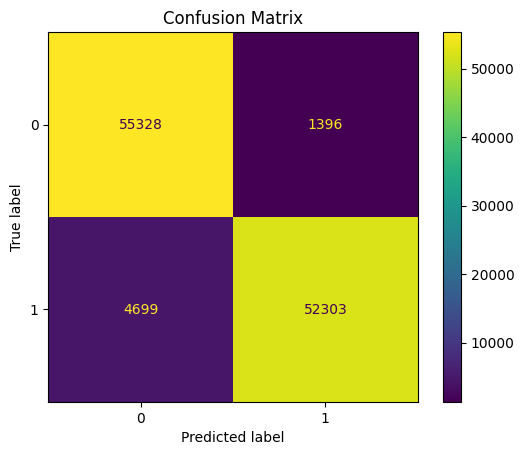

   Accuracy  Recall  Precision  F1 Score
0    0.9464  0.9176      0.974    0.9449


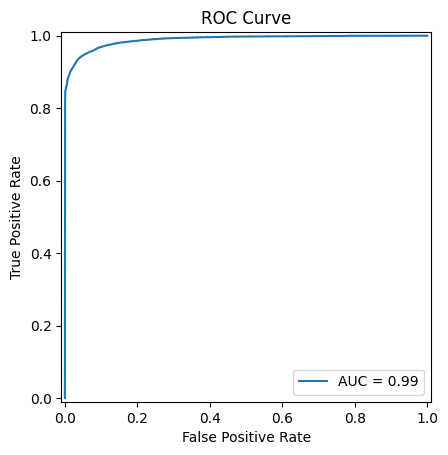

In [3]:
# Train Logistic Regression
logreg = LogisticRegression(max_iter=1000, random_state=42)
logreg.fit(X_train, y_train)

# Evaluation
train_score = logreg.score(X_train, y_train)
test_score = logreg.score(X_test, y_test)
print(f"Training Score: {train_score:.5f}")
print(f"Test Score: {test_score:.5f}")

# Predictions
logreg_preds = logreg.predict(X_test)
logreg_preds_prob = logreg.predict_proba(X_test)[:, 1]
logreg_preds_full = logreg.predict(X_full)
logreg_preds_full_prob = logreg.predict_proba(X_full)[:, 1]

# Add predictions to original dataset
dataset3 = dataset.copy()
dataset3['Data/output/logreg_predictions'] = logreg_preds_full
dataset3['Data/output/logreg_predictions_prob'] = logreg_preds_full_prob

# Confusion Matrix and Metrics
cm = confusion_matrix(y_test, logreg_preds)
ConfusionMatrixDisplay(cm).plot()
plt.title('Confusion Matrix')
plt.show()

metrics = pd.DataFrame({
    'Accuracy': [round(accuracy_score(y_test, logreg_preds), 4)],
    'Recall': [round(recall_score(y_test, logreg_preds), 4)],
    'Precision': [round(precision_score(y_test, logreg_preds), 4)],
    'F1 Score': [round(f1_score(y_test, logreg_preds), 4)]
})
print(metrics)

# ROC and AUC
fpr, tpr, thresh = roc_curve(y_test, logreg_preds_prob)
roc_auc = auc(fpr, tpr)
RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc).plot()
plt.title('ROC Curve')
plt.show()

# Export
metrics.to_csv("Data/output/logreg_metrics.csv", index=False)
pd.DataFrame({'fpr': fpr, 'tpr': tpr, 'thresh': thresh}).to_csv("Data/output/logreg_roc_curve_data.csv", index=False)
pd.DataFrame({'AUC': [roc_auc]}).to_csv("Data/output/logreg_auc.csv", index=False)
dataset3.to_csv("Data/output/logreg_predictions.csv", index=False)


## 4. Random Forest Classifier
Here we implement and evaluate a Random Forest classifier.

### Make Predictions and Evaluate Model
Predictions are made on the test set and evaluated using accuracy, precision, recall, and F1-score.

Training Score: 1.00000
Test Score: 0.99991


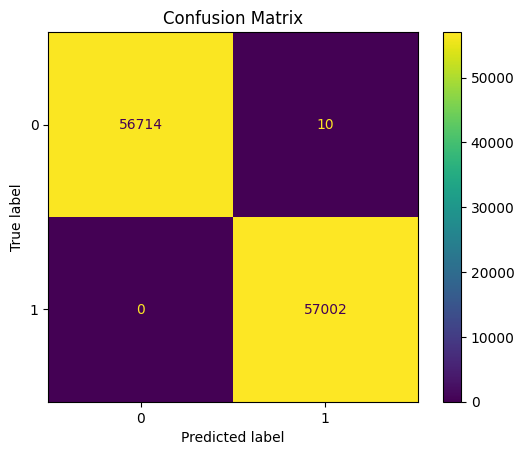

   Accuracy  Recall  Precision  F1 Score
0    0.9999     1.0     0.9998    0.9999


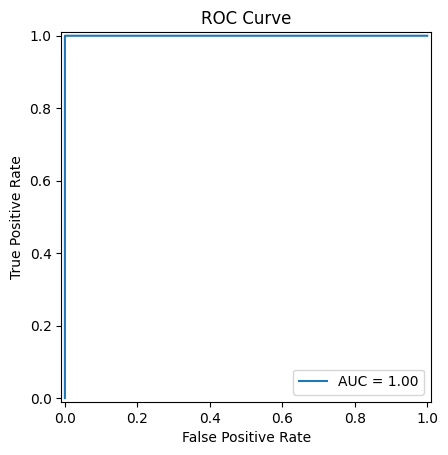

In [4]:
# Train Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Evaluation
train_score = rf.score(X_train, y_train)
test_score = rf.score(X_test, y_test)
print(f"Training Score: {train_score:.5f}")
print(f"Test Score: {test_score:.5f}")

# Predictions
rf_preds = rf.predict(X_test)
rf_preds_prob = rf.predict_proba(X_test)[:, 1]
rf_preds_full = rf.predict(X_full)
rf_preds_full_prob = rf.predict_proba(X_full)[:, 1]

# Add predictions to original dataset
dataset3 = dataset.copy()
dataset3['Data/output/rf_predictions'] = rf_preds_full
dataset3['Data/output/rf_predictions_prob'] = rf_preds_full_prob

# Confusion Matrix and Metrics
cm = confusion_matrix(y_test, rf_preds)
ConfusionMatrixDisplay(cm).plot()
plt.title('Confusion Matrix')
plt.show()

metrics = pd.DataFrame({
    'Accuracy': [round(accuracy_score(y_test, rf_preds), 4)],
    'Recall': [round(recall_score(y_test, rf_preds), 4)],
    'Precision': [round(precision_score(y_test, rf_preds), 4)],
    'F1 Score': [round(f1_score(y_test, rf_preds), 4)]
})
print(metrics)

# ROC and AUC
fpr, tpr, thresh = roc_curve(y_test, rf_preds_prob)
roc_auc = auc(fpr, tpr)
RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc).plot()
plt.title('ROC Curve')
plt.show()

# Export
metrics.to_csv("Data/output/rf_metrics.csv", index=False)
pd.DataFrame({'fpr': fpr, 'tpr': tpr, 'thresh': thresh}).to_csv("Data/output/rf_roc_curve_data.csv", index=False)
pd.DataFrame({'AUC': [roc_auc]}).to_csv("Data/output/rf_auc.csv", index=False)
dataset3.to_csv("Data/output/rf_predictions.csv", index=False)


## 5. LightGBM Classifier
We now train a LightGBM classifier and evaluate its performance similarly.

### Train LightGBM Model
We train a LightGBM model with default parameters.

[LightGBM] [Info] Number of positive: 227313, number of negative: 227591
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.040312 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 454904, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499694 -> initscore=-0.001222
[LightGBM] [Info] Start training from score -0.001222
Training Score: 0.99935
Test Score: 0.99916


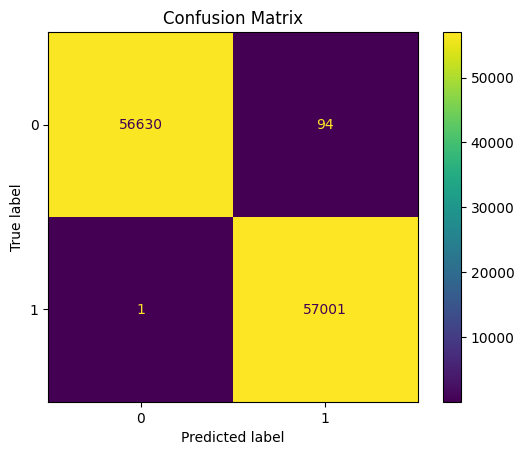

   Accuracy  Recall  Precision  F1 Score
0    0.9992     1.0     0.9984    0.9992


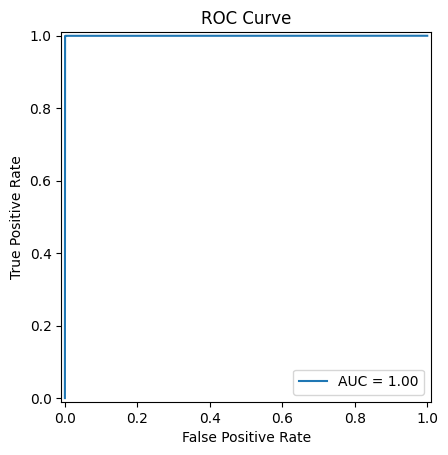

In [5]:
# Train LightGBM
lgbm = LGBMClassifier(random_state=42)
lgbm.fit(X_train, y_train)

# Evaluation
train_score = lgbm.score(X_train, y_train)
test_score = lgbm.score(X_test, y_test)
print(f"Training Score: {train_score:.5f}")
print(f"Test Score: {test_score:.5f}")

# Predictions
lgbm_preds = lgbm.predict(X_test)
lgbm_preds_prob = lgbm.predict_proba(X_test)[:, 1]
lgbm_preds_full = lgbm.predict(X_full)
lgbm_preds_full_prob = lgbm.predict_proba(X_full)[:, 1]

# Add predictions to original dataset
dataset3 = dataset.copy()
dataset3['Data/output/lgbm_predictions'] = lgbm_preds_full
dataset3['Data/output/lgbm_predictions_prob'] = lgbm_preds_full_prob

# Confusion Matrix and Metrics
cm = confusion_matrix(y_test, lgbm_preds)
ConfusionMatrixDisplay(cm).plot()
plt.title('Confusion Matrix')
plt.show()

metrics = pd.DataFrame({
    'Accuracy': [round(accuracy_score(y_test, lgbm_preds), 4)],
    'Recall': [round(recall_score(y_test, lgbm_preds), 4)],
    'Precision': [round(precision_score(y_test, lgbm_preds), 4)],
    'F1 Score': [round(f1_score(y_test, lgbm_preds), 4)]
})
print(metrics)

# ROC and AUC
fpr, tpr, thresh = roc_curve(y_test, lgbm_preds_prob)
roc_auc = auc(fpr, tpr)
RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc).plot()
plt.title('ROC Curve')
plt.show()

# Export
metrics.to_csv("Data/output/lgbm_metrics.csv", index=False)
pd.DataFrame({'fpr': fpr, 'tpr': tpr, 'thresh': thresh}).to_csv("Data/output/lgbm_roc_curve_data.csv", index=False)
pd.DataFrame({'AUC': [roc_auc]}).to_csv("Data/output/lgbm_auc.csv", index=False)
dataset3.to_csv("Data/output/lgbm_predictions.csv", index=False)


## 6. CatBoost Classifier
Finally, we train and evaluate a CatBoost classifier using the same pipeline.

### Train CatBoost Model
This cell trains a CatBoost classifier, useful when handling categorical features.

Training Score: 0.99984
Test Score: 0.99960


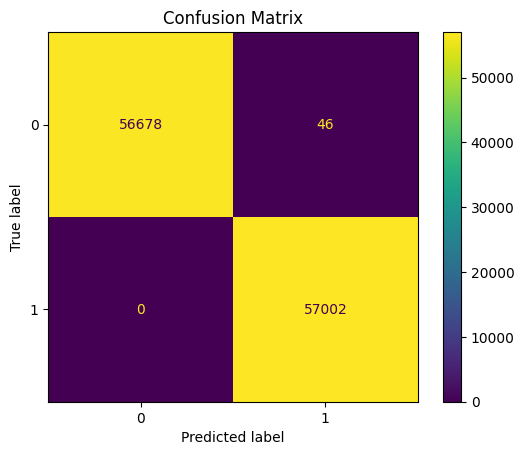

   Accuracy  Recall  Precision  F1 Score
0    0.9996     1.0     0.9992    0.9996


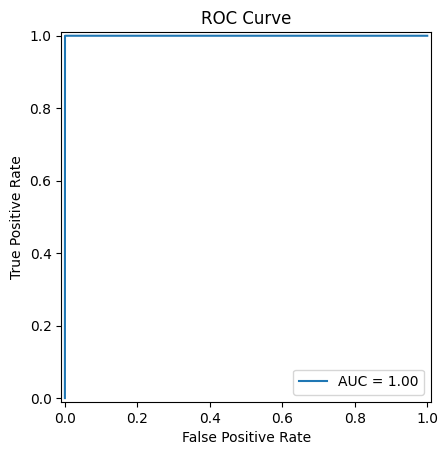

In [6]:
# Train CatBoost
cat = CatBoostClassifier(verbose=0, random_state=42)
cat.fit(X_train, y_train)

# Evaluation
train_score = cat.score(X_train, y_train)
test_score = cat.score(X_test, y_test)
print(f"Training Score: {train_score:.5f}")
print(f"Test Score: {test_score:.5f}")

# Predictions
cat_preds = cat.predict(X_test)
cat_preds_prob = cat.predict_proba(X_test)[:, 1]
cat_preds_full = cat.predict(X_full)
cat_preds_full_prob = cat.predict_proba(X_full)[:, 1]

# Add predictions to original dataset
dataset3 = dataset.copy()
dataset3['Data/output/cat_predictions'] = cat_preds_full
dataset3['Data/output/cat_predictions_prob'] = cat_preds_full_prob

# Confusion Matrix and Metrics
cm = confusion_matrix(y_test, cat_preds)
ConfusionMatrixDisplay(cm).plot()
plt.title('Confusion Matrix')
plt.show()

metrics = pd.DataFrame({
    'Accuracy': [round(accuracy_score(y_test, cat_preds), 4)],
    'Recall': [round(recall_score(y_test, cat_preds), 4)],
    'Precision': [round(precision_score(y_test, cat_preds), 4)],
    'F1 Score': [round(f1_score(y_test, cat_preds), 4)]
})
print(metrics)

# ROC and AUC
fpr, tpr, thresh = roc_curve(y_test, cat_preds_prob)
roc_auc = auc(fpr, tpr)
RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc).plot()
plt.title('ROC Curve')
plt.show()

# Export
metrics.to_csv("Data/output/cat_metrics.csv", index=False)
pd.DataFrame({'fpr': fpr, 'tpr': tpr, 'thresh': thresh}).to_csv("Data/output/cat_roc_curve_data.csv", index=False)
pd.DataFrame({'AUC': [roc_auc]}).to_csv("Data/output/cat_auc.csv", index=False)
dataset3.to_csv("Data/output/cat_predictions.csv", index=False)


## 7. Model Comparison Summary
We compare the evaluation metrics of all models side-by-side in a summary table.

### Load Input Data
This step reads input data required for training or evaluation from the specified CSV files.

In [7]:
# Collect metrics from all models
summary_df = pd.DataFrame({
    'Model': ['XGBoost', 'Logistic Regression', 'Random Forest', 'LightGBM', 'CatBoost'],
    'Accuracy': [
        metrics['Accuracy'].values[0],
        #pd.read_csv('Data/output/xgboost_metrics.csv')['Accuracy'][0],
        pd.read_csv('Data/output/logreg_metrics.csv')['Accuracy'][0],
        pd.read_csv('Data/output/rf_metrics.csv')['Accuracy'][0],
        pd.read_csv('Data/output/lgbm_metrics.csv')['Accuracy'][0],
        pd.read_csv('Data/output/cat_metrics.csv')['Accuracy'][0]
    ],
    'Recall': [
        metrics['Recall'].values[0],
        #pd.read_csv('Data/output/xgboost_metrics.csv')['Recall'][0],
        pd.read_csv('Data/output/logreg_metrics.csv')['Recall'][0],
        pd.read_csv('Data/output/rf_metrics.csv')['Recall'][0],
        pd.read_csv('Data/output/lgbm_metrics.csv')['Recall'][0],
        pd.read_csv('Data/output/cat_metrics.csv')['Recall'][0]
    ],
    'Precision': [
        metrics['Precision'].values[0],
        #pd.read_csv('Data/output/xgboost_metrics.csv')['Precision'][0],
        pd.read_csv('Data/output/logreg_metrics.csv')['Precision'][0],
        pd.read_csv('Data/output/rf_metrics.csv')['Precision'][0],
        pd.read_csv('Data/output/lgbm_metrics.csv')['Precision'][0],
        pd.read_csv('Data/output/cat_metrics.csv')['Precision'][0]
    ],
    'F1 Score': [
        metrics['F1 Score'].values[0],
        #pd.read_csv('Data/output/xgboost_metrics.csv')['F1 Score'][0],
        pd.read_csv('Data/output/logreg_metrics.csv')['F1 Score'][0],
        pd.read_csv('Data/output/rf_metrics.csv')['F1 Score'][0],
        pd.read_csv('Data/output/lgbm_metrics.csv')['F1 Score'][0],
        pd.read_csv('Data/output/cat_metrics.csv')['F1 Score'][0]
    ]
})
summary_df.to_csv("Data/output/model_comparison_summary.csv", index=False)
summary_df


,Model,Accuracy,Recall,Precision,F1 Score
0,XGBoost,0.9996,1.0000,0.9992,0.9996
1,Logistic Regression,0.9464,0.9176,0.9740,0.9449
2,Random Forest,0.9999,1.0000,0.9998,0.9999
3,LightGBM,0.9992,1.0000,0.9984,0.9992
4,CatBoost,0.9996,1.0000,0.9992,0.9996


## 8. Hyperparameter Tuning with GridSearchCV
We perform hyperparameter tuning on XGBoost using GridSearchCV to find the best parameters.

### Train XGBoost Model
We initialize and train an XGBoost classifier using the balanced dataset.

In [8]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid for XGBoost
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1],
    'n_estimators': [100, 200],
    'subsample': [0.8, 1.0]
}

xgb_tune = XGBClassifier(eval_metric='logloss', random_state=42)
grid_search = GridSearchCV(estimator=xgb_tune, param_grid=param_grid, cv=3, scoring='f1', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
best_xgb = grid_search.best_estimator_

# Evaluate tuned model
xgb_tuned_preds = best_xgb.predict(X_test)
xgb_tuned_probs = best_xgb.predict_proba(X_test)[:, 1]
tuned_metrics = pd.DataFrame({
    'Accuracy': [accuracy_score(y_test, xgb_tuned_preds)],
    'Recall': [recall_score(y_test, xgb_tuned_preds)],
    'Precision': [precision_score(y_test, xgb_tuned_preds)],
    'F1 Score': [f1_score(y_test, xgb_tuned_preds)]
})
print(tuned_metrics)


Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best Parameters: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}
   Accuracy  Recall  Precision  F1 Score
0   0.99971     1.0   0.999421  0.999711


## 9. Ensemble Model (Voting Classifier)
We combine XGBoost, Random Forest, and Logistic Regression into an ensemble Voting Classifier to leverage their strengths.

### Train XGBoost Model
We initialize and train an XGBoost classifier using the balanced dataset.

In [9]:
from sklearn.ensemble import VotingClassifier

# Define base models
xgb_base = XGBClassifier(eval_metric='logloss', random_state=42)
rf_base = RandomForestClassifier(n_estimators=100, random_state=42)
logreg_base = LogisticRegression(max_iter=1000, random_state=42)

# Create ensemble model
voting_clf = VotingClassifier(estimators=[
    ('xgb', xgb_base),
    ('rf', rf_base),
    ('lr', logreg_base)
], voting='soft')

voting_clf.fit(X_train, y_train)
ensemble_preds = voting_clf.predict(X_test)
ensemble_probs = voting_clf.predict_proba(X_test)[:, 1]

# Evaluate ensemble
ensemble_metrics = pd.DataFrame({
    'Accuracy': [accuracy_score(y_test, ensemble_preds)],
    'Recall': [recall_score(y_test, ensemble_preds)],
    'Precision': [precision_score(y_test, ensemble_preds)],
    'F1 Score': [f1_score(y_test, ensemble_preds)]
})
print(ensemble_metrics)

# Save to CSV
ensemble_metrics.to_csv("Data/output/ensemble_metrics.csv", index=False)


   Accuracy  Recall  Precision  F1 Score
0   0.99978     1.0   0.999562  0.999781


## 10. Stacking Ensemble
We use StackingClassifier to combine base models and a meta-model for improved performance.

### Train XGBoost Model
We initialize and train an XGBoost classifier using the balanced dataset.

In [10]:
from sklearn.ensemble import StackingClassifier

# Define base learners and meta-learner
estimators = [
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('lr', LogisticRegression(max_iter=1000, random_state=42)),
    ('xgb', XGBClassifier(eval_metric='logloss', random_state=42))
]

stack_model = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(), cv=3)
stack_model.fit(X_train, y_train)

stack_preds = stack_model.predict(X_test)
stack_probs = stack_model.predict_proba(X_test)[:, 1]

stack_metrics = pd.DataFrame({
    'Accuracy': [accuracy_score(y_test, stack_preds)],
    'Recall': [recall_score(y_test, stack_preds)],
    'Precision': [precision_score(y_test, stack_preds)],
    'F1 Score': [f1_score(y_test, stack_preds)]
})
print(stack_metrics)

stack_metrics.to_csv("Data/output/stacking_metrics.csv", index=False)


   Accuracy  Recall  Precision  F1 Score
0  0.999877     1.0   0.999754  0.999877


## 11. AutoML-Style Comparison Table
Aggregate metrics from all models including tuned and ensemble methods for a final comparison.

### Load Input Data
This step reads input data required for training or evaluation from the specified CSV files.

In [11]:
final_summary_df = pd.DataFrame({
    'Model': ['XGBoost', 'XGBoost Tuned', 'Logistic Regression', 'Random Forest', 'LightGBM', 'CatBoost', 'Voting Ensemble', 'Stacking Ensemble'],
    'Accuracy': [
        metrics['Accuracy'].values[0],
        tuned_metrics['Accuracy'].values[0],
        pd.read_csv('Data/output/logreg_metrics.csv')['Accuracy'][0],
        pd.read_csv('Data/output/rf_metrics.csv')['Accuracy'][0],
        pd.read_csv('Data/output/lgbm_metrics.csv')['Accuracy'][0],
        pd.read_csv('Data/output/cat_metrics.csv')['Accuracy'][0],
        pd.read_csv('Data/output/ensemble_metrics.csv')['Accuracy'][0],
        pd.read_csv('Data/output/stacking_metrics.csv')['Accuracy'][0]
    ],
    'Recall': [
        metrics['Recall'].values[0],
        tuned_metrics['Recall'].values[0],
        pd.read_csv('Data/output/logreg_metrics.csv')['Recall'][0],
        pd.read_csv('Data/output/rf_metrics.csv')['Recall'][0],
        pd.read_csv('Data/output/lgbm_metrics.csv')['Recall'][0],
        pd.read_csv('Data/output/cat_metrics.csv')['Recall'][0],
        pd.read_csv('Data/output/ensemble_metrics.csv')['Recall'][0],
        pd.read_csv('Data/output/stacking_metrics.csv')['Recall'][0]
    ],
    'Precision': [
        metrics['Precision'].values[0],
        tuned_metrics['Precision'].values[0],
        pd.read_csv('Data/output/logreg_metrics.csv')['Precision'][0],
        pd.read_csv('Data/output/rf_metrics.csv')['Precision'][0],
        pd.read_csv('Data/output/lgbm_metrics.csv')['Precision'][0],
        pd.read_csv('Data/output/cat_metrics.csv')['Precision'][0],
        pd.read_csv('Data/output/ensemble_metrics.csv')['Precision'][0],
        pd.read_csv('Data/output/stacking_metrics.csv')['Precision'][0]
    ],
    'F1 Score': [
        metrics['F1 Score'].values[0],
        tuned_metrics['F1 Score'].values[0],
        pd.read_csv('Data/output/logreg_metrics.csv')['F1 Score'][0],
        pd.read_csv('Data/output/rf_metrics.csv')['F1 Score'][0],
        pd.read_csv('Data/output/lgbm_metrics.csv')['F1 Score'][0],
        pd.read_csv('Data/output/cat_metrics.csv')['F1 Score'][0],
        pd.read_csv('Data/output/ensemble_metrics.csv')['F1 Score'][0],
        pd.read_csv('Data/output/stacking_metrics.csv')['F1 Score'][0]
    ]
})

final_summary_df.to_csv("Data/output/automl_model_summary.csv", index=False)
final_summary_df


,Model,Accuracy,Recall,Precision,F1 Score
0,XGBoost,0.999600,1.0000,0.999200,0.999600
1,XGBoost Tuned,0.999710,1.0000,0.999421,0.999711
2,Logistic Regression,0.946400,0.9176,0.974000,0.944900
3,Random Forest,0.999900,1.0000,0.999800,0.999900
4,LightGBM,0.999200,1.0000,0.998400,0.999200
5,CatBoost,0.999600,1.0000,0.999200,0.999600
6,Voting Ensemble,0.999780,1.0000,0.999562,0.999781
7,Stacking Ensemble,0.999877,1.0000,0.999754,0.999877


## 12. Deployment-Ready Script Generator
Export the best model and required transformers for future inference (e.g. in Flask or Streamlit).

### Load Input Data
This step reads input data required for training or evaluation from the specified CSV files.

In [12]:
import joblib

# Save best model (e.g. best_xgb from GridSearchCV)
joblib.dump(best_xgb, 'best_model_xgb.pkl')
joblib.dump(scaler, 'scaler.pkl')

# Save prediction logic script
with open("predict_script.py", "w") as f:
    f.write("""import pandas as pd
import joblib

# Load model and scaler
model = joblib.load('best_model_xgb.pkl')
scaler = joblib.load('scaler.pkl')

def predict_from_csv(input_csv):
    df = pd.read_csv(input_csv)
    df['Scaled_Amount'] = scaler.transform(df['Amount'].values.reshape(-1, 1))
    df = df.drop(['Amount', 'Time'], axis=1)
    predictions = model.predict(df.drop('Class', axis=1))
    probabilities = model.predict_proba(df.drop('Class', axis=1))[:, 1]
    df['Prediction'] = predictions
    df['Probability'] = probabilities
    df.to_csv('predicted_output.csv', index=False)
    print('Prediction complete. Saved to predicted_output.csv')

# Example: predict_from_csv('new_data.csv')
""")
